In [14]:
import pandas as pd
import numpy as np
import re
import io
import matplotlib.pyplot as plt
import yfinance as yf  
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['font.family'] = 'Tahoma'

# กำหนดชื่อไฟล์และพารามิเตอร์การโหลดที่จำเป็น (เช่น header สำหรับ CPI)
file_configs = {
    "df_cpi": {
        "file_name": "CPI-G_Report.csv",
        # ไฟล์ CPI มีข้อมูลหัวข้อ 4 บรรทัด ต้องเริ่มอ่านที่แถวที่ 5 (index 4)
        "read_params": {"header": 4, "encoding": "utf-8"} 
    },
    "df_exchange": {
        "file_name": "exchange_rate.csv",
        "read_params": {"encoding": "utf-8"}
    },
    "df_gold": {
        "file_name": "ingest_gold.csv",
        "read_params": {"encoding": "utf-8"}
    },
    "df_gold_history": {  
        "file_name": "gold_history.csv",
        "read_params": {"encoding": "utf-8"}
    },
    "df_petroleum": {
        "file_name": "petroleum_data.csv",
        "read_params": {"encoding": "utf-8"}
    },
    "df_set": {
        "file_name": "set_index.csv",
        "read_params": {"header": [0, 1], "encoding": "utf-8"} # SET Index มี 2 แถว header ที่ซ้ำซ้อน
    }
}

# พจนานุกรมสำหรับเก็บ DataFrame ที่โหลดแล้ว
dataframes = {}

# เพิ่มฟังก์ชันสำหรับโหลดข้อมูล Bitcoin
def load_bitcoin_data(start_date="2018-01-01", end_date=pd.to_datetime('today').strftime('%Y-%m-%d')):
    """ดึงข้อมูลราคา Bitcoin (BTC-USD) รายวันจาก Yahoo Finance"""
    # ใช้ ticker "BTC-USD" เพื่อดึงข้อมูล Bitcoin
    try:
        btc_data = yf.download("BTC-USD", start=start_date, end=end_date, progress=False, auto_adjust=False)
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการดึงข้อมูล Bitcoin: {e}")
        return pd.DataFrame()
    
    if btc_data.empty:
        print("!! ไม่สามารถดึงข้อมูล Bitcoin ได้ !!")
        return pd.DataFrame()
    
    # ใช้เฉพาะคอลัมน์ Close และปรับชื่อคอลัมน์
    btc_df = btc_data[['Close']].copy()
    btc_df.index.name = 'Date'
    btc_df.rename(columns={'Close': 'Bitcoin_Close'}, inplace=True)
    
    print(f"\n======== df_bitcoin (BTC-USD) ========")
    print(f"** รูปแบบข้อมูล (Shape): {btc_df.shape[0]} แถว, {btc_df.shape[1]} คอลัมน์")
    print("** ตัวอย่างข้อมูล 5 แถวแรก:")
    print(btc_df.head())
    print("-" * 50)
    
    return btc_df

# เพิ่ม df_bitcoin ใน dataframes
dataframes['df_bitcoin'] = load_bitcoin_data()


======== df_bitcoin (BTC-USD) ========
** รูปแบบข้อมูล (Shape): 2867 แถว, 1 คอลัมน์
** ตัวอย่างข้อมูล 5 แถวแรก:
Price      Bitcoin_Close
Ticker           BTC-USD
Date                    
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
2018-01-05  17429.500000
--------------------------------------------------


In [15]:
# -----------------------------------------------------------
# ส่วนที่ 1: การโหลดข้อมูลและการแสดงตัวอย่าง (head)
# -----------------------------------------------------------
print("--- 1. การโหลดข้อมูลและแสดงตัวอย่าง 5 แถวแรก (.head()) ---")
for df_name, config in file_configs.items():
    try:
        # โหลดข้อมูลตามชื่อไฟล์และพารามิเตอร์ที่กำหนด
        df = pd.read_csv(config["file_name"], **config["read_params"])
        dataframes[df_name] = df
        
        print(f"\n======== {df_name} ({config['file_name']}) ========")
        print(f"** รูปแบบข้อมูล (Shape): {df.shape[0]} แถว, {df.shape[1]} คอลัมน์")
        print("** ตัวอย่างข้อมูล 5 แถวแรก:")
        print(df.head())
        print("-" * 50)
        
    except FileNotFoundError:
        print(f"ไม่พบไฟล์: {config['file_name']}")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการอ่านไฟล์ {config['file_name']}: {e}")

--- 1. การโหลดข้อมูลและแสดงตัวอย่าง 5 แถวแรก (.head()) ---

======== df_cpi (CPI-G_Report.csv) ========
** รูปแบบข้อมูล (Shape): 539 แถว, 19 คอลัมน์
** ตัวอย่างข้อมูล 5 แถวแรก:
    รหัส                                   หมวด    ปี    ม.ค.    ก.พ.   มี.ค.  \
0      0                           รวมทุกรายการ  2568  100.57  100.55  100.35   
1  10000  หมวดอาหารและเครื่องดื่มไม่มีแอลกอฮอล์  2568  101.16  101.08  101.27   
2  11000                       อาหารปรุงที่บ้าน  2568   99.99   99.72  100.26   
3  11100          ข้าว  แป้งและผลิตภัณฑ์จากแป้ง  2568  103.85  103.29  103.82   
4  11110                                   ข้าว  2568  104.50  103.67  104.23   

    เม.ย.    พ.ค.   มิ.ย.    ก.ค.    ส.ค.    ก.ย. ต.ค. พ.ย. ธ.ค.  Unnamed: 15  \
0  100.14  100.40  100.42  100.15  100.14  100.11    -    -    -          NaN   
1  101.76  102.40  102.47  101.86  101.71  101.81    -    -    -          NaN   
2  100.93  101.42  101.50  100.42   99.94  100.13    -    -    -          NaN   
3  103.66  1

In [16]:
# -----------------------------------------------------------
# ส่วนที่ 2: การตรวจสอบประเภทข้อมูลและค่าว่าง (.info() และ .isnull().sum())
# -----------------------------------------------------------
print("\n\n--- 2. การตรวจสอบประเภทข้อมูล (Data Types) และค่าว่าง (Missing Values) ---")

# รวม df ที่โหลดจากไฟล์และ df_bitcoin เพื่อตรวจสอบทั้งหมด
all_dataframes = dataframes.copy()

for df_name, df in all_dataframes.items():
    print(f"\n======== {df_name} (Data Types and Missing Values) ========")
    
    # 2.1 ตรวจสอบประเภทข้อมูลและ Non-Null Count (.info())
    df.info()
    
    # 2.2 ระบุจำนวนค่าว่างทั้งหมดในแต่ละคอลัมน์
    print("\n** จำนวนค่าว่าง (Missing Values Count) **")
    missing_count = df.isnull().sum()
    print(missing_count[missing_count > 0]) # แสดงเฉพาะคอลัมน์ที่มีค่าว่าง



--- 2. การตรวจสอบประเภทข้อมูล (Data Types) และค่าว่าง (Missing Values) ---

======== df_bitcoin (Data Types and Missing Values) ========
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2867 entries, 2018-01-01 to 2025-11-06
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   (Bitcoin_Close, BTC-USD)  2867 non-null   float64
dtypes: float64(1)
memory usage: 44.8 KB

** จำนวนค่าว่าง (Missing Values Count) **
Series([], dtype: int64)

======== df_cpi (Data Types and Missing Values) ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   รหัส         539 non-null    int64  
 1   หมวด         539 non-null    object 
 2   ปี           539 non-null    int64  
 3   ม.ค.         539 non-null    object 
 4   ก.พ.         539 non-null    object 
 5   ม

In [17]:
# -----------------------------------------------------------
# ส่วนที่ 3: การสรุปสถิติเชิงปริมาณ (.describe())
# -----------------------------------------------------------
print("\n\n--- 3. การสรุปสถิติเชิงปริมาณ (.describe()) ---")
for df_name, df in dataframes.items():
    print(f"\n======== {df_name} (Summary Statistics) ========")
    # แสดงสถิติเชิงสรุปสำหรับคอลัมน์ที่เป็นตัวเลขเท่านั้น
    print(df.describe())



--- 3. การสรุปสถิติเชิงปริมาณ (.describe()) ---

======== df_bitcoin (Summary Statistics) ========
Price   Bitcoin_Close
Ticker        BTC-USD
count     2867.000000
mean     36241.169859
std      31630.378513
min       3236.761719
25%       9375.181152
50%      26862.375000
75%      55249.380859
max     124752.531250

======== df_cpi (Summary Statistics) ========
               รหัส           ปี  Unnamed: 15  Unnamed: 16  Unnamed: 17  \
count    539.000000   539.000000          0.0          0.0          0.0   
mean   36212.569573  2567.025974          NaN          NaN          NaN   
std    21758.917443     0.822134          NaN          NaN          NaN   
min        0.000000  2566.000000          NaN          NaN          NaN   
25%    21100.000000  2566.000000          NaN          NaN          NaN   
50%    32200.000000  2567.000000          NaN          NaN          NaN   
75%    53200.000000  2568.000000          NaN          NaN          NaN   
max    96000.000000  2568.000000

In [18]:
# Cleaning and Preparation (Date, Number, Missing Values)

# A. df_cpi: CPI Index (Monthly)
df_cpi = dataframes["df_cpi"].copy()
df_cpi = df_cpi[df_cpi['รหัส'] == 0].copy()
if df_cpi.empty:
    df_cpi = dataframes["df_cpi"][dataframes["df_cpi"]['รหัส'] == 00000].copy()
month_cols = ['ม.ค.', 'ก.พ.', 'มี.ค.', 'เม.ย.', 'พ.ค.', 'มิ.ย.', 'ก.ค.', 'ส.ค.', 'ก.ย.', 'ต.ค.', 'พ.ย.', 'ธ.ค.']
df_cpi_long = df_cpi.melt(id_vars=['ปี'], value_vars=month_cols, var_name='Month_TH', value_name='CPI_Index')
df_cpi_long = df_cpi_long.dropna(subset=['CPI_Index'])
month_map = {'ม.ค.': '01', 'ก.พ.': '02', 'มี.ค.': '03', 'เม.ย.': '04', 'พ.ค.': '05', 'มิ.ย.': '06', 'ก.ค.': '07', 'ส.ค.': '08', 'ก.ย.': '09', 'ต.ค.': '10', 'พ.ย.': '11', 'ธ.ค.': '12'}
df_cpi_long['Month_Num'] = df_cpi_long['Month_TH'].map(month_map)
df_cpi_long['Year_AD'] = df_cpi_long['ปี'].astype(int) - 543
df_cpi_long['Date'] = pd.to_datetime(df_cpi_long['Year_AD'].astype(str) + '-' + df_cpi_long['Month_Num'], format='%Y-%m')
df_cpi_long['CPI_Index'] = df_cpi_long['CPI_Index'].replace('-', np.nan, regex=False)
df_cpi_long['CPI_Index'] = pd.to_numeric(df_cpi_long['CPI_Index'], errors='coerce')
df_cpi_final = df_cpi_long[['Date', 'CPI_Index']].set_index('Date').sort_index().dropna(subset=['CPI_Index'])
df_cpi_final['CPI_Index'] = df_cpi_final['CPI_Index'].ffill()
dataframes["df_cpi_final"] = df_cpi_final


# B. df_exchange: Exchange Rate (USD, Monthly) 
df_exchange = dataframes["df_exchange"].copy()
df_exchange = df_exchange[df_exchange['currency_id'] == 'USD'].copy()
df_exchange['Date'] = pd.to_datetime(df_exchange['period'], format='%Y-%m')
df_exchange_final = df_exchange.set_index('Date').sort_index()
target_cols = ['mid_rate', 'buying_sight', 'selling']
for col in target_cols:
    df_exchange_final[col] = pd.to_numeric(df_exchange_final[col], errors='coerce')
df_exchange_final[target_cols] = df_exchange_final[target_cols].ffill()
dataframes["df_exchange_final"] = df_exchange_final[target_cols]


# C. df_gold: Gold Price (Daily) (ใช้ parsing วันที่ไทย)
df_gold = dataframes["df_gold"].copy()
month_th_map = {'มกราคม': 1, 'กุมภาพันธ์': 2, 'มีนาคม': 3, 'เมษายน': 4, 'พฤษภาคม': 5, 'มิถุนายน': 6, 'กรกฎาคม': 7, 'สิงหาคม': 8, 'กันยายน': 9, 'ตุลาคม': 10, 'พฤศจิกายน': 11, 'ธันวาคม': 12}
def parse_thai_date(date_str):
    try:
        parts = date_str.split(' ')
        if len(parts) == 3:
            day = int(parts[0])
            month = month_th_map.get(parts[1])
            year_be = int(parts[2])
            if month and year_be > 2400:
                year_ad = year_be - 543
                return pd.to_datetime(f"{year_ad}-{month:02d}-{day:02d}")
        return pd.NaT
    except:
        return pd.NaT

df_gold['Date'] = df_gold['date'].apply(parse_thai_date)
df_gold.dropna(subset=['Date'], inplace=True)
df_gold_final = df_gold.set_index('Date').sort_index().dropna(subset=['gold_bar_sell'])
target_cols_gold = ['gold_buy', 'gold_sell', 'gold_bar_buy', 'gold_bar_sell']
for col in target_cols_gold:
    df_gold_final[col] = df_gold_final[col].astype(str).str.replace(r'[\",]', '', regex=True)
    df_gold_final[col] = pd.to_numeric(df_gold_final[col], errors='coerce')
df_gold_final[target_cols_gold] = df_gold_final[target_cols_gold].ffill()
dataframes["df_gold_final"] = df_gold_final[target_cols_gold]


# C-1. df_gold_history: Gold Price History (Daily) - แก้ไข
df_gold_history = dataframes["df_gold_history"].copy()
# แปลงวันที่ BE (25xx) เป็น AD (20xx) โดยใช้คอลัมน์ 'date' (ตัวเล็ก)
def parse_thai_date_short(date_str):
    try:
        # Format DD/MM/YYYY (BE)
        day, month, year_be = map(int, date_str.split('/'))
        year_ad = year_be - 543
        return pd.to_datetime(f"{year_ad}-{month:02d}-{day:02d}")
    except:
        return pd.NaT

# ***แก้ไข: เปลี่ยน df_gold_history['Date'] เป็น df_gold_history['date'] เพื่อดึงค่าเดิม***
df_gold_history['Date'] = df_gold_history['date'].apply(parse_thai_date_short) 
df_gold_history.dropna(subset=['Date'], inplace=True)

# ใช้ 'gold_bar_sell' และทำความสะอาดข้อมูลตัวเลข
df_gold_history_final = df_gold_history.set_index('Date').sort_index()
df_gold_history_final['gold_bar_sell_hist'] = df_gold_history_final['gold_bar_sell'].astype(str).str.replace(r'[\",]', '', regex=True)
df_gold_history_final['gold_bar_sell_hist'] = pd.to_numeric(df_gold_history_final['gold_bar_sell_hist'], errors='coerce')

df_gold_history_final = df_gold_history_final[['gold_bar_sell_hist']].dropna(subset=['gold_bar_sell_hist']).ffill()
dataframes["df_gold_history_final"] = df_gold_history_final


# D. df_petroleum: Petroleum Price (Monthly) 
df_petroleum = dataframes["df_petroleum"].copy()
df_petroleum = df_petroleum[df_petroleum['series'] == 'EMM_EPMRU_PTE_NUS_DPG'].copy() # U.S. Regular Conventional Gasoline
df_petroleum['Date'] = pd.to_datetime(df_petroleum['period'], format='%Y-%m')
df_petroleum_final = df_petroleum.set_index('Date').sort_index()
df_petroleum_final['value'] = pd.to_numeric(df_petroleum_final['value'], errors='coerce').ffill()
dataframes["df_petroleum_final"] = df_petroleum_final[['value']].rename(columns={'value': 'Petroleum_Price_USD_per_Gal'})


# E. df_set: SET Index (Daily) 
df_set = dataframes["df_set"].copy()
df_set.columns = df_set.columns.get_level_values(0)
df_set['date'] = pd.to_datetime(df_set['date'], errors='coerce')
df_set.dropna(subset=['date'], inplace=True)
df_set_final = df_set.set_index('date').sort_index().dropna(subset=['Close'])
target_cols_set = ['Close', 'High', 'Low', 'Open', 'Volume']
for col in target_cols_set:
    df_set_final[col] = pd.to_numeric(df_set_final[col], errors='coerce')
df_set_final[target_cols_set] = df_set_final[target_cols_set].ffill()
dataframes["df_set_final"] = df_set_final[target_cols_set]


# F. df_bitcoin: Bitcoin Price (Daily)
df_bitcoin_daily = dataframes["df_bitcoin"].copy() 
# เนื่องจากโหลดและทำความสะอาดเบื้องต้นใน Cell 1 แล้ว จึงตั้งชื่อ final dataframe เลย
df_bitcoin_daily_final = df_bitcoin_daily.dropna()
dataframes["df_bitcoin_final"] = df_bitcoin_daily_final

print("Cleaning and Preparation complete. Individual final DataFrames are created (e.g., df_cpi_final).")

Cleaning and Preparation complete. Individual final DataFrames are created (e.g., df_cpi_final).


In [21]:
# Cell 5: Resampling and Merging (Monthly Consolidation)

print("--- Resampling Daily Data to Monthly and Merging ---")

# 1. Resample Daily Data to Monthly (using last value of the month)
df_gold_monthly = dataframes['df_gold_final'].resample('ME').last()
df_gold_history_monthly = dataframes['df_gold_history_final'].resample('ME').last() 
df_bitcoin_monthly = dataframes['df_bitcoin_final'].resample('ME').last()          
df_set_monthly = dataframes['df_set_final'].resample('ME').last()

# 2. Prepare list of all monthly DataFrames
monthly_dfs = [
    dataframes['df_cpi_final'],
    dataframes['df_exchange_final'],
    dataframes['df_petroleum_final'],
    df_gold_monthly,
    df_gold_history_monthly,                                                       
    df_bitcoin_monthly.rename(columns={'Bitcoin_Close': 'Bitcoin_Price_Close'}),   
    df_set_monthly[['Close']].rename(columns={'Close': 'SET_Index_Close'})
]

# ***FIX START: การแก้ไขเพื่อบังคับให้ Column Index เป็นระดับเดียว***
# ลูปเพื่อตรวจสอบและปรับปรุง Column Index ของทุก DataFrame ในรายการ
for i, df in enumerate(monthly_dfs):
    if df.columns.nlevels > 1:
        # ดึง Column Index ระดับบนสุด (Level 0) มาใช้
        monthly_dfs[i].columns = monthly_dfs[i].columns.get_level_values(0)
        print(f"INFO: Flattened column index for monthly_dfs[{i}]")
# ***FIX END***

# 3. Perform Outer Merge
final_combined_df = monthly_dfs[0].copy()
for i in range(1, len(monthly_dfs)):
    final_combined_df = final_combined_df.merge(
        monthly_dfs[i],
        left_index=True,
        right_index=True,
        how='outer'
    )

# 4. Final cleaning and sorting
final_combined_df.index.name = 'Date'
final_combined_df = final_combined_df.sort_index()
final_combined_df = final_combined_df.ffill() # จัดการค่าว่างที่เกิดจากการรวมด้วย Ffill
final_combined_df = final_combined_df.dropna(how='all')

print("Merging complete. Final DataFrame created: final_combined_df.")

--- Resampling Daily Data to Monthly and Merging ---
INFO: Flattened column index for monthly_dfs[5]
Merging complete. Final DataFrame created: final_combined_df.


In [22]:
# Final Inspection and Save
print("--- Final Inspection and Save ---")

print("\n======== FINAL COMBINED MONTHLY DATA ========")
print(f"** รูปแบบข้อมูล (Shape): {final_combined_df.shape}")
print(f"** ช่วงวันที่เริ่มต้น - สิ้นสุด: {final_combined_df.index.min().strftime('%Y-%m')} ถึง {final_combined_df.index.max().strftime('%Y-%m')}")

print("\n** ตัวอย่าง 5 แถวแรก **")
print(final_combined_df.head().to_markdown())

print("\n** ตัวอย่าง 5 แถวสุดท้าย **")
print(final_combined_df.tail().to_markdown())

# บันทึกไฟล์ CSV ที่รวมแล้ว
final_combined_df.to_csv("combined_economic_data_monthly.csv")
print("\nSUCCESS: Data Cleaning and Preparation complete. File saved as combined_economic_data_monthly.csv")

--- Final Inspection and Save ---

======== FINAL COMBINED MONTHLY DATA ========
** รูปแบบข้อมูล (Shape): (128, 12)
** ช่วงวันที่เริ่มต้น - สิ้นสุด: 2018-01 ถึง 2025-11

** ตัวอย่าง 5 แถวแรก **
| Date                |   CPI_Index |   mid_rate |   buying_sight |   selling |   Petroleum_Price_USD_per_Gal |   gold_buy |   gold_sell |   gold_bar_buy |   gold_bar_sell |   gold_bar_sell_hist |   Bitcoin_Price_Close |   SET_Index_Close |
|:--------------------|------------:|-----------:|---------------:|----------:|------------------------------:|-----------:|------------:|---------------:|----------------:|---------------------:|----------------------:|------------------:|
| 2018-01-31 00:00:00 |         nan |        nan |            nan |       nan |                           nan |        nan |         nan |            nan |             nan |                  nan |              10221.1  |               nan |
| 2018-02-28 00:00:00 |         nan |        nan |            nan |       nan |    

In [36]:
# Feature Engineering (Combined MoM, Lag, Rolling, Calendar)

# 1. โหลด Final Combined DataFrame 
try:
    final_combined_df = pd.read_csv("combined_economic_data_monthly.csv", index_col='Date', parse_dates=True)
except FileNotFoundError:
    print("Error: ไม่พบไฟล์ combined_economic_data_monthly.csv กรุณาย้อนกลับไปรัน Cell 1-5")
    raise

print("--- Feature Engineering: All Features ---")

# กำหนดคอลัมน์หลักที่ใช้ในการวิเคราะห์ 
main_cols = [
    'CPI_Index', 
    'mid_rate', 
    'gold_bar_sell', 
    'gold_bar_sell_hist', 
    'Petroleum_Price_USD_per_Gal', 
    'SET_Index_Close',
    'Bitcoin_Price_Close' 
]
# ตัวแปรสำหรับการสร้าง MoM Change Plot (เลือกตัวแทนที่สนใจ) 
cols_to_plot = [
    'CPI_Index_MoM_Change', 
    'mid_rate_MoM_Change', 
    'Petroleum_Price_USD_per_Gal_MoM_Change', 
    'SET_Index_Close_MoM_Change',
    'gold_bar_sell_hist_MoM_Change',
    'Bitcoin_Price_Close_MoM_Change' 
]


# ================================================================
# 1. MoM % Change 
# ================================================================
for col in main_cols:
    final_combined_df[f'{col}_MoM_Change'] = final_combined_df[col].pct_change() * 100

# กรองข้อมูล MoM Change (ลบ NaN ที่เกิดจากการคำนวณ MoM)
final_combined_df_change = final_combined_df[cols_to_plot].dropna()
print("Created MoM % Change Features.")


# ================================================================
# 2. Lag Features 
# ================================================================

# เลือก Lag Variables ที่ต้องการ
lag_variables = ['CPI_Index', 'Petroleum_Price_USD_per_Gal', 'Bitcoin_Price_Close'] 
lags = [1, 3]

for var in lag_variables:
    for l in lags:
        new_col_name = f'{var}_Lag_{l}M'
        final_combined_df[new_col_name] = final_combined_df[var].shift(l)
        # print(f"Created Lag Feature: {new_col_name}")


# ================================================================
# 3. Rolling Features 
# ================================================================

roll_window = 3
# เลือก Rolling Variables ที่ต้องการ
rolling_variables = ['mid_rate', 'SET_Index_Close', 'gold_bar_sell_hist', 'Bitcoin_Price_Close'] 

for var in rolling_variables:
    # Rolling Mean 3 เดือน
    new_mean_col = f'{var}_RollMean_{roll_window}M'
    final_combined_df[new_mean_col] = final_combined_df[var].rolling(window=roll_window).mean()
    # Rolling Standard Deviation 3 เดือน
    new_std_col = f'{var}_RollStd_{roll_window}M'
    final_combined_df[new_std_col] = final_combined_df[var].rolling(window=roll_window).std()


# ================================================================
# 4. Calendar Features 
# ================================================================

# Month Number (1-12)
final_combined_df['Month_Num'] = final_combined_df.index.month
print("Created Lag, Rolling, and Calendar Features.")


# ================================================================
# 5. สรุปผลลัพธ์และบันทึก
# ================================================================

print("\nFeature Engineering Complete. Saving the fully featured file.")
print(final_combined_df.filter(regex='(Lag|RollMean|RollStd|Month_Num|MoM|Bitcoin|Gold_History)').tail().to_markdown())

# บันทึกไฟล์ CSV ที่มีการเพิ่ม Feature ใหม่ (ทับไฟล์เดิม)
final_combined_df.to_csv("combined_economic_data_monthly.csv")

print("\nSUCCESS: All Features created and saved. Proceed to Cell 8 (Univariate) หรือ Cell 12 (Multivariate).")

--- Feature Engineering: All Features ---
Created MoM % Change Features.
Created Lag, Rolling, and Calendar Features.

Feature Engineering Complete. Saving the fully featured file.
| Date                |   Bitcoin_Price_Close |   CPI_Index_MoM_Change |   mid_rate_MoM_Change |   gold_bar_sell_MoM_Change |   gold_bar_sell_hist_MoM_Change |   Petroleum_Price_USD_per_Gal_MoM_Change |   SET_Index_Close_MoM_Change |   Bitcoin_Price_Close_MoM_Change |   CPI_Index_Lag_1M |   CPI_Index_Lag_3M |   Petroleum_Price_USD_per_Gal_Lag_1M |   Petroleum_Price_USD_per_Gal_Lag_3M |   Bitcoin_Price_Close_Lag_1M |   Bitcoin_Price_Close_Lag_3M |   mid_rate_RollMean_3M |   mid_rate_RollStd_3M |   SET_Index_Close_RollMean_3M |   SET_Index_Close_RollStd_3M |   gold_bar_sell_hist_RollMean_3M |   gold_bar_sell_hist_RollStd_3M |   Bitcoin_Price_Close_RollMean_3M |   Bitcoin_Price_Close_RollStd_3M |   Month_Num |
|:--------------------|----------------------:|-----------------------:|----------------------:|------

In [26]:
# Cell 8: Univariate Analysis - Define Full Thai Names

# โหลด Final Combined DataFrame
try:
    final_combined_df = pd.read_csv("combined_economic_data_monthly.csv", index_col='Date', parse_dates=True)
except FileNotFoundError:
    print("Error: ไม่พบไฟล์ combined_economic_data_monthly.csv กรุณาย้อนกลับไปรัน Cell 1-7")
    raise

print("--- Defining Thai Names for Plotting ---")

# กำหนดชื่อเต็มภาษาไทยสำหรับคอลัมน์ต่างๆ
thai_names_full = {
    'CPI_Index': 'ดัชนีราคาผู้บริโภคทั่วไป (CPI)',
    'mid_rate': 'อัตราแลกเปลี่ยน (USD/THB)',
    'gold_bar_sell': 'ราคาทองแท่งขายออก (Ingest)',
    'gold_bar_sell_hist': 'ราคาทองแท่งขายออก (Historical)', 
    'Petroleum_Price_USD_per_Gal': 'ราคาน้ำมันเบนซิน (USD/GAL)',
    'SET_Index_Close': 'ดัชนี SET (ราคาปิดรายเดือน)',
    'Bitcoin_Price_Close': 'ราคา Bitcoin (USD)',           
    'CPI_Index_MoM_Change': 'การเปลี่ยนแปลง CPI MoM (%)',
    'mid_rate_MoM_Change': 'การเปลี่ยนแปลงอัตราแลกเปลี่ยน MoM (%)',
    'gold_bar_sell_MoM_Change': 'การเปลี่ยนแปลงราคาทอง (Ingest) MoM (%)',
    'gold_bar_sell_hist_MoM_Change': 'การเปลี่ยนแปลงราคาทอง (Historical) MoM (%)', 
    'Petroleum_Price_USD_per_Gal_MoM_Change': 'การเปลี่ยนแปลงราคาน้ำมัน MoM (%)',
    'SET_Index_Close_MoM_Change': 'การเปลี่ยนแปลง SET Index MoM (%)',
    'Bitcoin_Price_Close_MoM_Change': 'การเปลี่ยนแปลงราคา Bitcoin MoM (%)'  
}

# กำหนดกลุ่มตัวแปรที่ต้องการวิเคราะห์
# ใช้ Historical Gold เป็นตัวแทนในการวิเคราะห์ MoM Change
cols_to_plot_mom_change = [
    'CPI_Index_MoM_Change', 
    'mid_rate_MoM_Change', 
    'Petroleum_Price_USD_per_Gal_MoM_Change', 
    'SET_Index_Close_MoM_Change',
    'gold_bar_sell_hist_MoM_Change', 
    'Bitcoin_Price_Close_MoM_Change'
]

# ตัวแปรหลักทั้งหมด (ใช้ Historical Gold เป็นตัวแทนในการวิเคราะห์ Time Series)
main_analysis_cols = [
    'CPI_Index', 
    'mid_rate', 
    'gold_bar_sell_hist',
    'Petroleum_Price_USD_per_Gal', 
    'SET_Index_Close',
    'Bitcoin_Price_Close'
]

print("Thai names defined and analysis columns configured.")

--- Defining Thai Names for Plotting ---
Thai names defined and analysis columns configured.


Saved MoM Change Plots: univariate_mom_change_plots.png


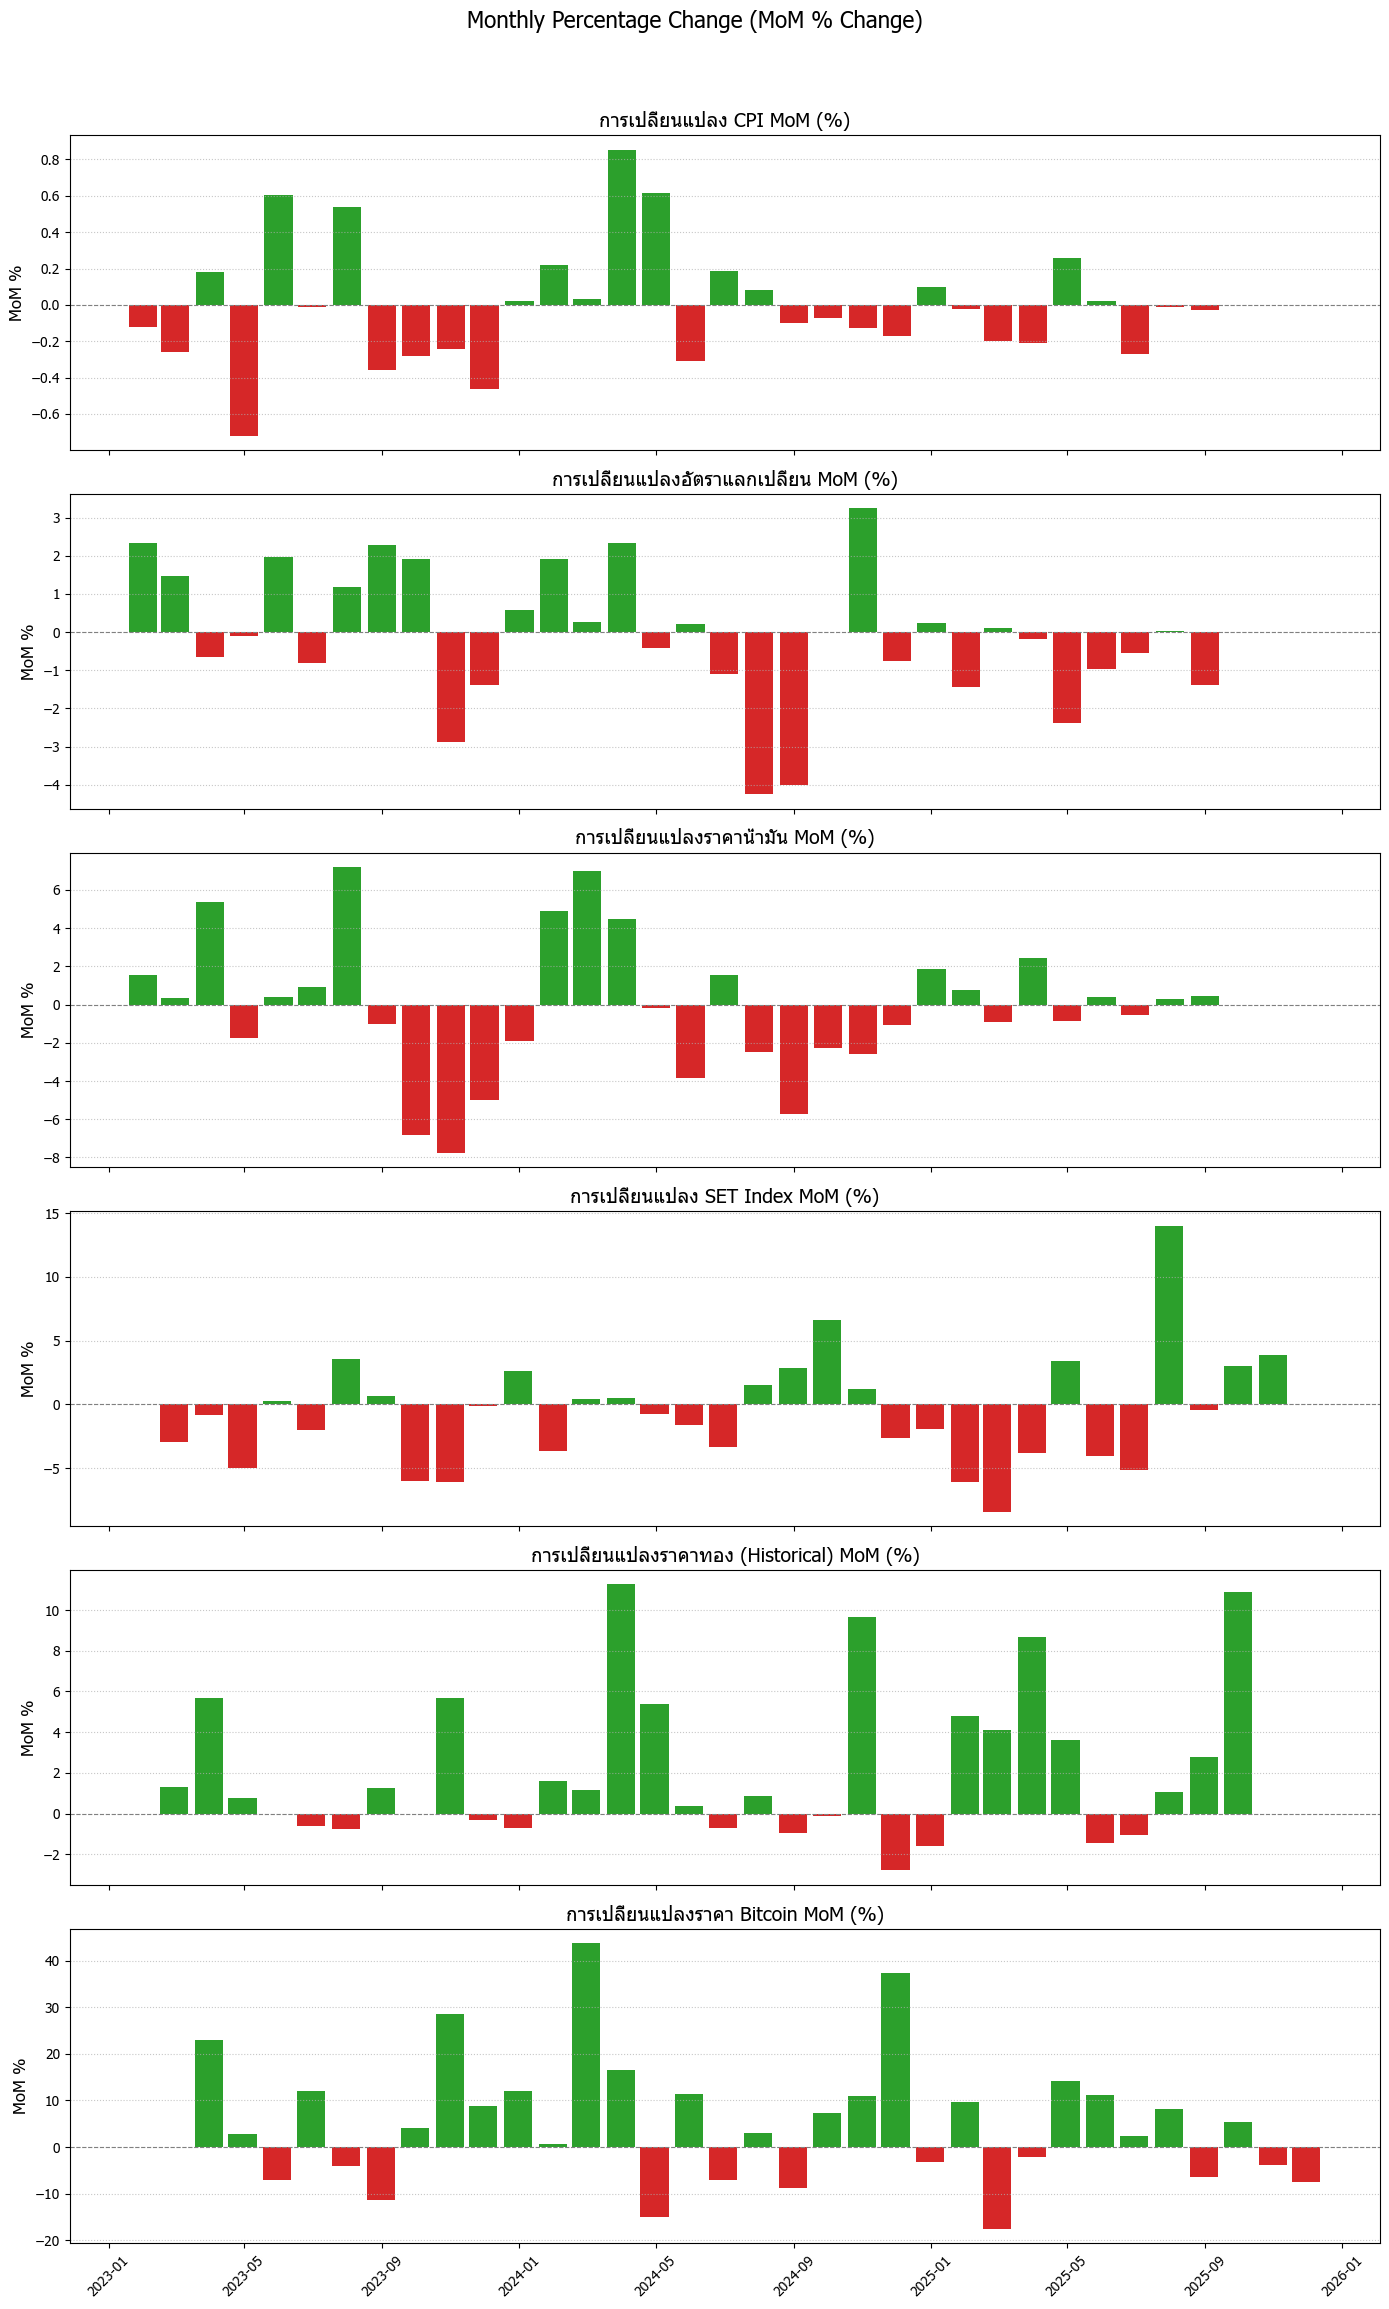

In [27]:
# Cell 9: Univariate Analysis - Plotting MoM Change

# โหลดข้อมูล MoM Change
cols_to_plot = [
    'CPI_Index_MoM_Change', 
    'mid_rate_MoM_Change', 
    'Petroleum_Price_USD_per_Gal_MoM_Change', 
    'SET_Index_Close_MoM_Change',
    'gold_bar_sell_hist_MoM_Change', 
    'Bitcoin_Price_Close_MoM_Change'
]
df_mom_change_plot = final_combined_df[cols_to_plot].dropna()

# สร้างกราฟ MoM Change
num_cols = len(cols_to_plot)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(14, 4 * num_cols))
fig.suptitle('Monthly Percentage Change (MoM % Change)', fontsize=16, y=0.99)

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    # พล็อตค่า MoM Change
    ax.bar(df_mom_change_plot.index, df_mom_change_plot[col], 
           color=np.where(df_mom_change_plot[col] >= 0, 'tab:green', 'tab:red'), 
           width=25) 
    
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # เส้น 0%
    ax.set_title(thai_names_full.get(col, col), fontsize=14)
    ax.set_ylabel('MoM %', fontsize=12)
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # ซ่อนแกน x ของกราฟด้านบน (ยกเว้นกราฟสุดท้าย)
    if i < num_cols - 1:
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("univariate_mom_change_plots.png")
print("Saved MoM Change Plots: univariate_mom_change_plots.png")

Saved Time Series Plots: univariate_time_series_plots.png


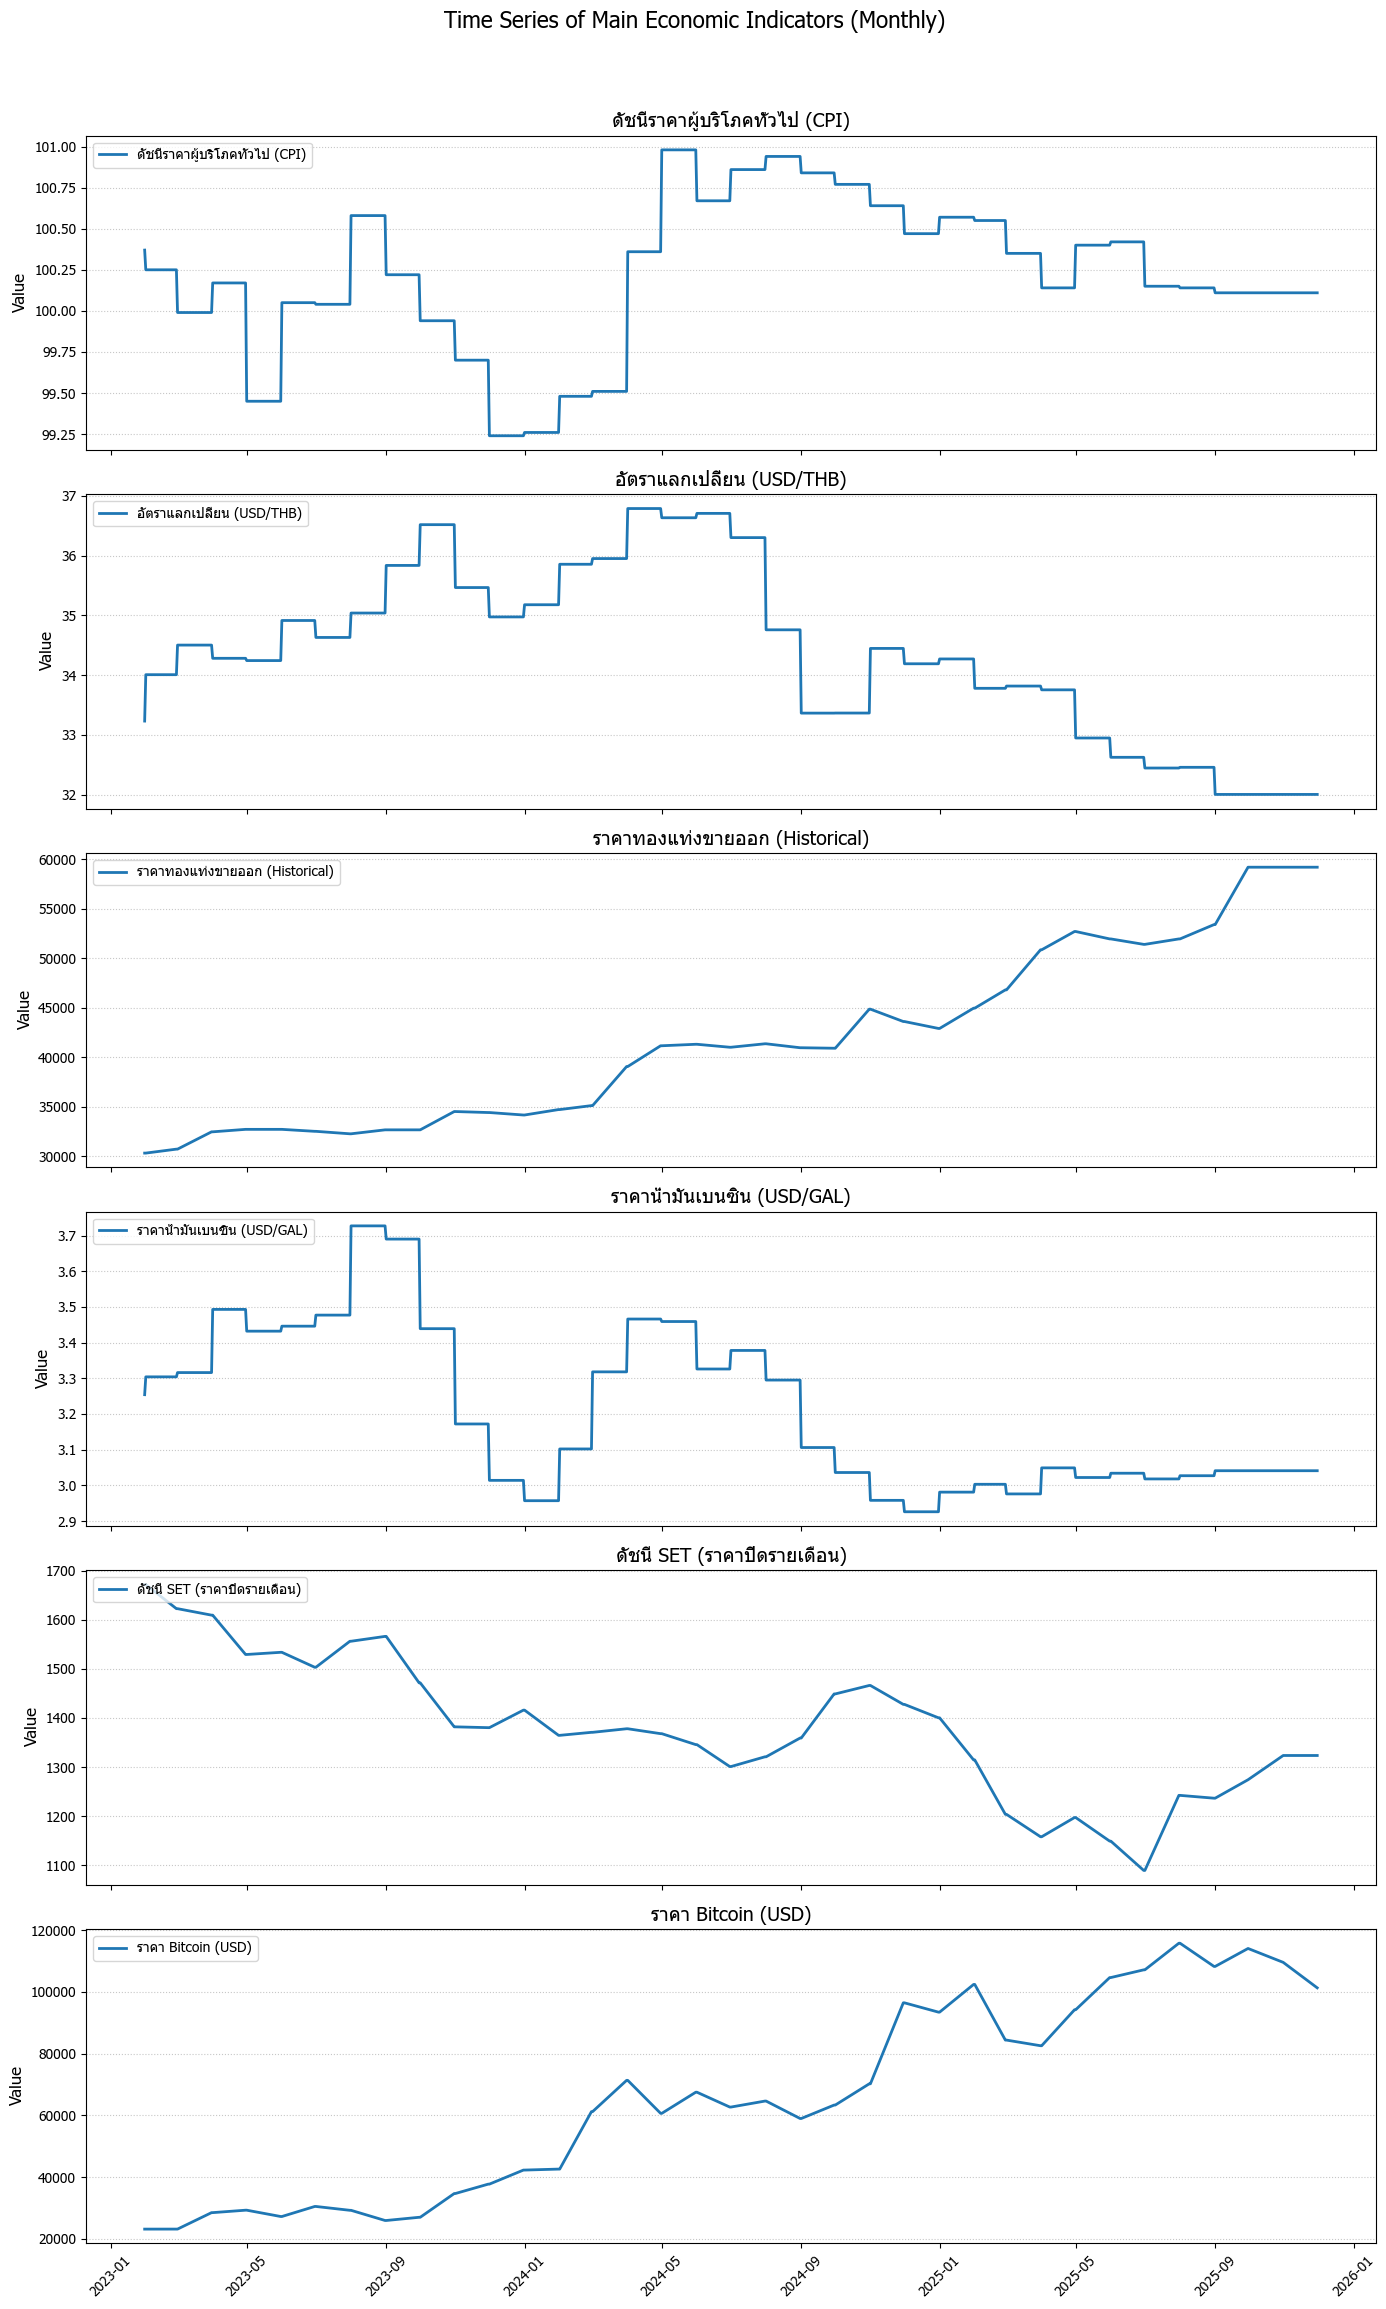

In [28]:
# Cell 10: Univariate Analysis - Plotting Original Time Series

df_ts_plot = final_combined_df[main_analysis_cols].dropna()

num_cols = len(main_analysis_cols)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(14, 4 * num_cols))
fig.suptitle('Time Series of Main Economic Indicators (Monthly)', fontsize=16, y=0.99)

for i, col in enumerate(main_analysis_cols):
    ax = axes[i]
    ax.plot(df_ts_plot.index, df_ts_plot[col], label=thai_names_full.get(col, col), linewidth=2)
    
    ax.set_title(thai_names_full.get(col, col), fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    ax.legend(loc='upper left')
    
    # ซ่อนแกน x ของกราฟด้านบน (ยกเว้นกราฟสุดท้าย)
    if i < num_cols - 1:
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("univariate_time_series_plots.png")
print("Saved Time Series Plots: univariate_time_series_plots.png")

Saved Time Series Decomposition Plot: univariate_decomposition.png


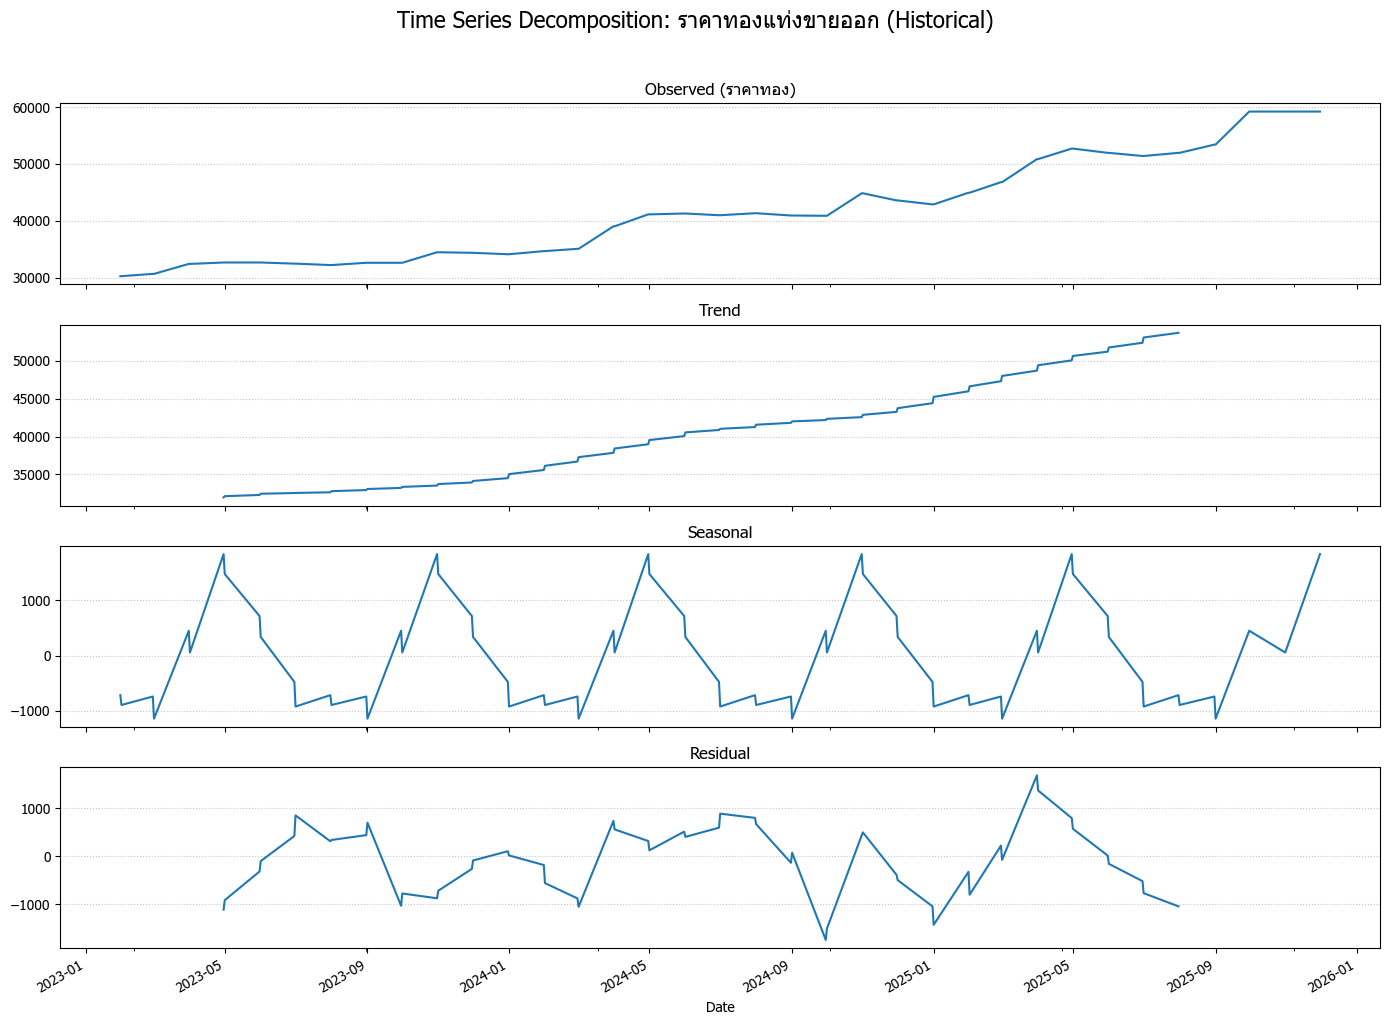

In [29]:
# Cell 11: Univariate Analysis - Time Series Decomposition

decomposition_col = 'gold_bar_sell_hist'
df_decomp = final_combined_df[[decomposition_col]].dropna()

# ต้องมีข้อมูลอย่างน้อย 2 รอบฤดูกาล (24 เดือน) เพื่อการ decomposition ที่เหมาะสม
if len(df_decomp) >= 24:
    decomposition = seasonal_decompose(df_decomp[decomposition_col], model='additive', period=12) # 12 เดือนต่อ 1 ฤดูกาล
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    decomposition.observed.plot(ax=axes[0], legend=False, title='Observed (ราคาทอง)')
    axes[0].grid(axis='y', linestyle=':', alpha=0.7)
    
    decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
    axes[1].grid(axis='y', linestyle=':', alpha=0.7)
    
    decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
    axes[2].grid(axis='y', linestyle=':', alpha=0.7)
    
    decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
    axes[3].grid(axis='y', linestyle=':', alpha=0.7)
    
    fig.suptitle(f'Time Series Decomposition: {thai_names_full.get(decomposition_col, decomposition_col)}', fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.savefig("univariate_decomposition.png")
    print("Saved Time Series Decomposition Plot: univariate_decomposition.png")
else:
    print(f"Skipping Decomposition for {decomposition_col}: Not enough data points (need > 24, have {len(df_decomp)}).")

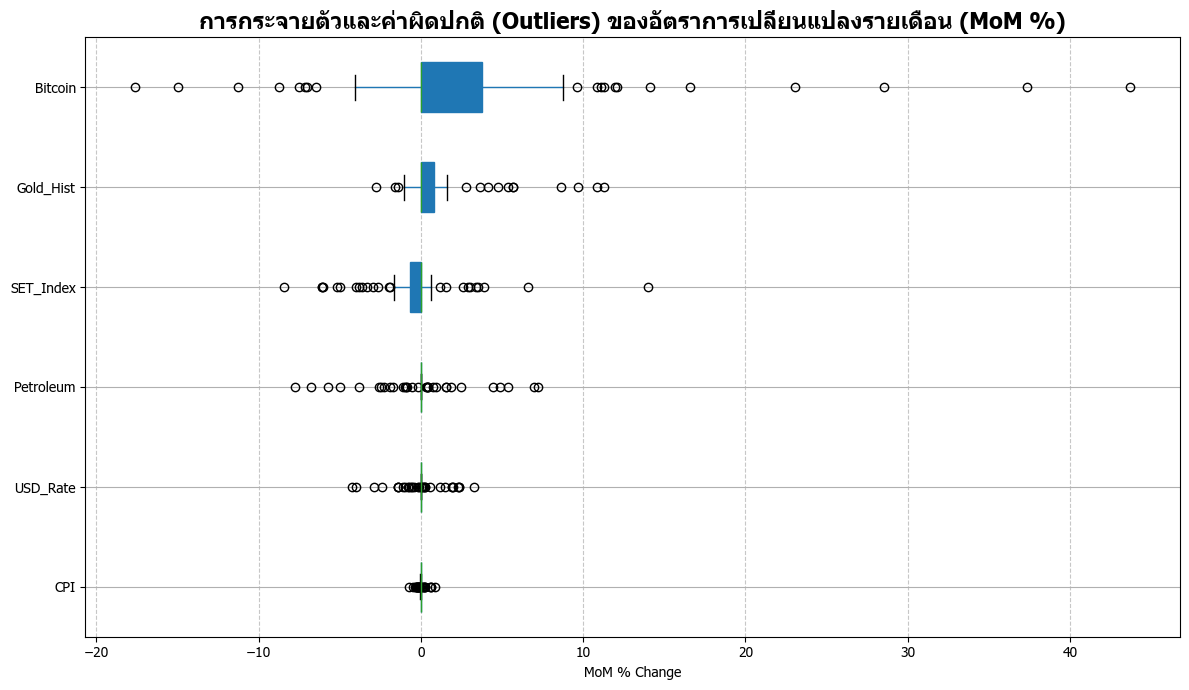

In [37]:
# Univariate Analysis: Box Plots (Distribution and Outliers of MoM % Change)

# 1. เตรียมข้อมูล
df_boxplot = final_combined_df_change.copy()
# ชื่อคอลัมน์ที่เหลืออยู่จริง 6 คอลัมน์ (ตามผลลัพธ์: ['CPI', 'USD_Rate', 'Petroleum', 'SET_Index', 'Gold_Hist', 'Bitcoin'])
df_boxplot.columns = ['CPI', 'USD_Rate', 'Petroleum', 'SET_Index', 'Gold_Hist', 'Bitcoin'] 

# 2. สร้าง Box Plot
plt.figure(figsize=(12, 7))
df_boxplot.boxplot(vert=False, patch_artist=True)
plt.title('การกระจายตัวและค่าผิดปกติ (Outliers) ของอัตราการเปลี่ยนแปลงรายเดือน (MoM %)', fontsize=16, fontweight='bold')
plt.xlabel('MoM % Change')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("univariate_box_plots_mom_change_fixed_final.png")

--- Time Series Decomposition (CPI Index) ---
Saved Time Series Decomposition Plot: decomposition_cpi_index.png


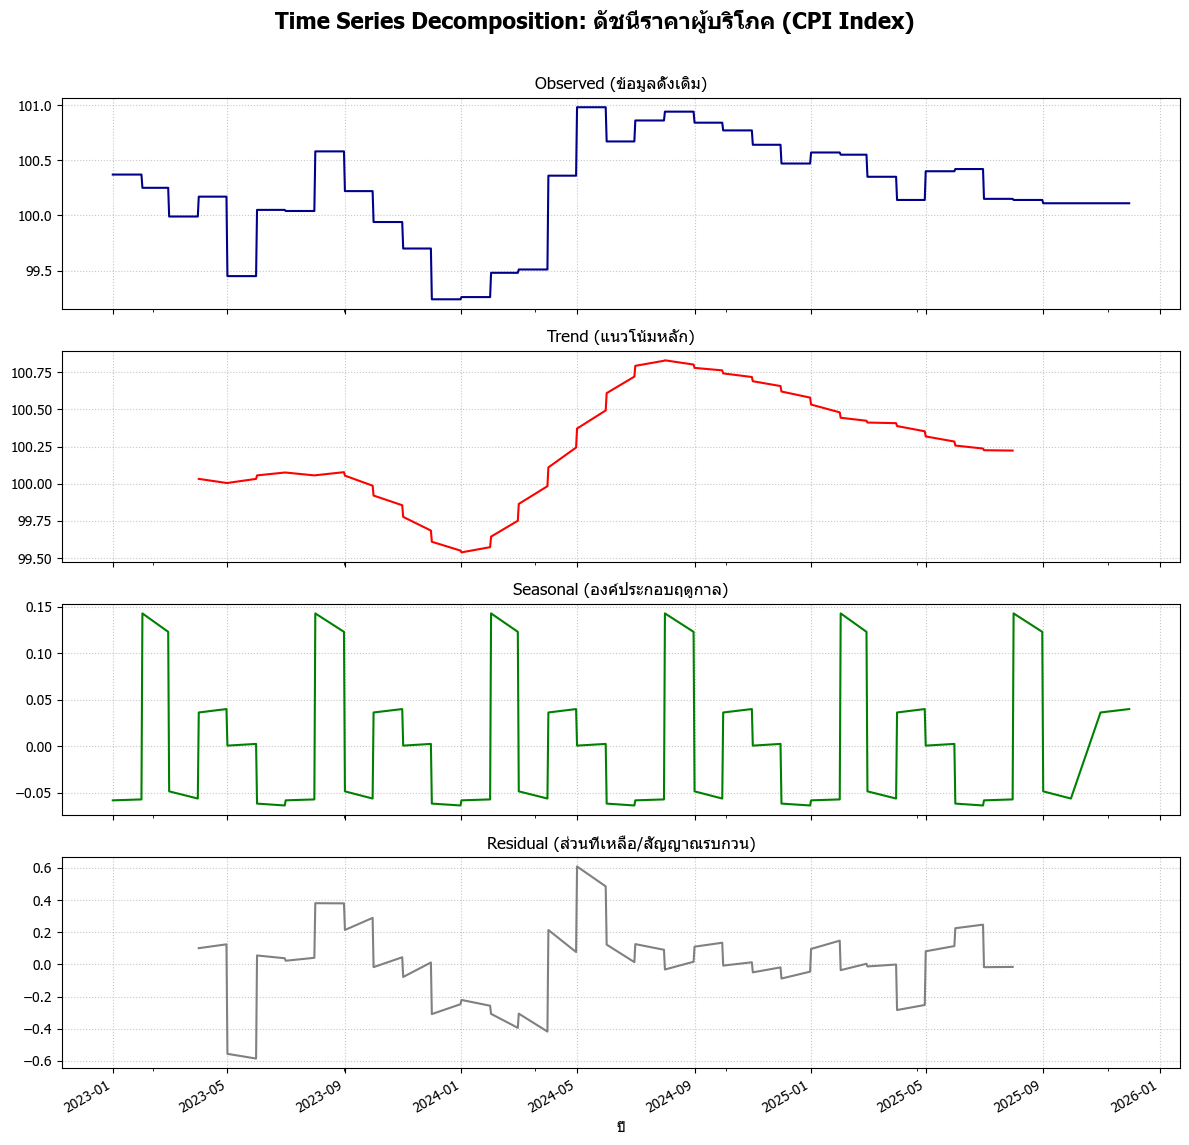

In [30]:
# Time Series Decomposition (CPI Index)
print("--- Time Series Decomposition (CPI Index) ---")

# 1. เลือกตัวแปร CPI Index
ts_cpi = final_combined_df['CPI_Index'].dropna()

# 2. ทำ Decomposition (Additive Model, Period: 12 สำหรับข้อมูลรายเดือน)
decomposition = seasonal_decompose(ts_cpi, model='additive', period=12)

# 3. พล็อตผลลัพธ์
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle('Time Series Decomposition: ดัชนีราคาผู้บริโภค (CPI Index)', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], title='Observed (ข้อมูลดั้งเดิม)', color='darkblue')
decomposition.trend.plot(ax=axes[1], title='Trend (แนวโน้มหลัก)', color='red')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal (องค์ประกอบฤดูกาล)', color='green')
decomposition.resid.plot(ax=axes[3], title='Residual (ส่วนที่เหลือ/สัญญาณรบกวน)', color='gray')

for ax in axes:
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_xlabel("ปี")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("decomposition_cpi_index.png")
print("Saved Time Series Decomposition Plot: decomposition_cpi_index.png")

Saved Correlation Matrix: multivariate_correlation_matrix.png


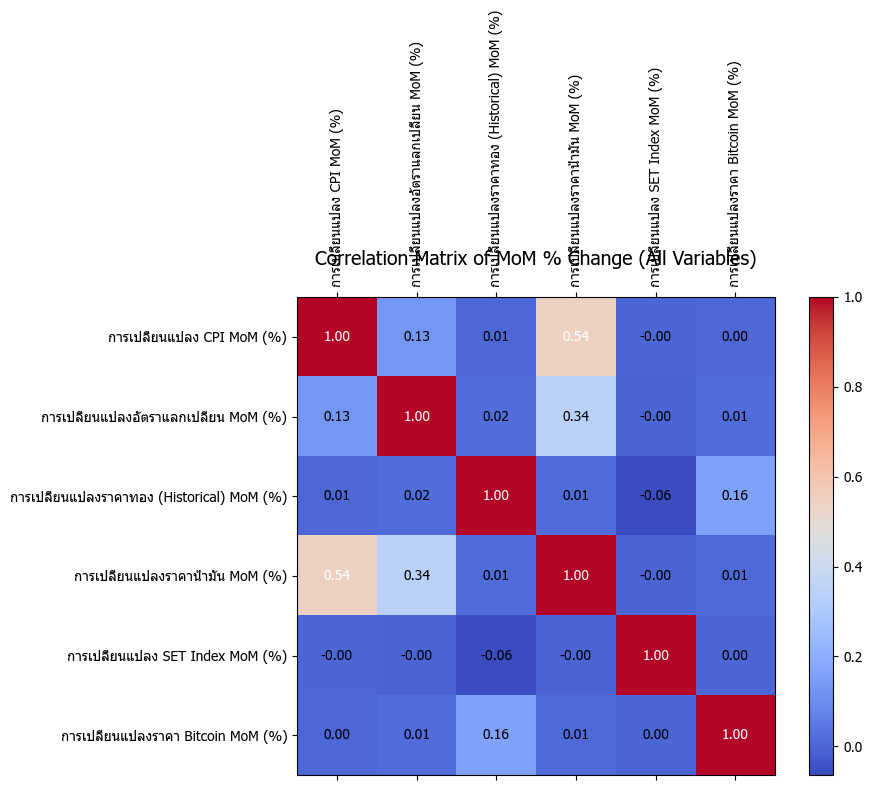

In [31]:
# Cell 12: Multivariate Analysis - Correlation Matrix (Heatmap)

# เลือกเฉพาะคอลัมน์หลักสำหรับ Correlation (ใช้ MoM Change เพื่อความสัมพันธ์ระยะสั้น)
correlation_cols = [
    'CPI_Index_MoM_Change', 
    'mid_rate_MoM_Change', 
    'gold_bar_sell_hist_MoM_Change', 
    'Petroleum_Price_USD_per_Gal_MoM_Change', 
    'SET_Index_Close_MoM_Change',
    'Bitcoin_Price_Close_MoM_Change'
]

# ใช้ DataFrame ที่มี MoM Change (final_combined_df_change)
df_corr = final_combined_df[correlation_cols].dropna()

# Map ชื่อคอลัมน์เป็นชื่อภาษาไทย
thai_labels = [thai_names_full.get(col, col) for col in correlation_cols]

# คำนวณ Correlation Matrix
corr_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))
# สร้าง Heatmap
cax = ax.matshow(corr_matrix, cmap='coolwarm')
plt.colorbar(cax)

# ตั้งค่าแกน x และ y ด้วยชื่อภาษาไทย
ax.set_xticks(np.arange(len(thai_labels)))
ax.set_yticks(np.arange(len(thai_labels)))
ax.set_xticklabels(thai_labels, rotation=90)
ax.set_yticklabels(thai_labels)

# แสดงค่า Correlation ในแต่ละ Cell
for i in range(len(thai_labels)):
    for j in range(len(thai_labels)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="w" if np.abs(corr_matrix.iloc[i, j]) > 0.5 else "k")

plt.title('Correlation Matrix of MoM % Change (All Variables)', fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig("multivariate_correlation_matrix.png")
print("Saved Correlation Matrix: multivariate_correlation_matrix.png")

Saved Scatter Plots: multivariate_scatter_plots.png


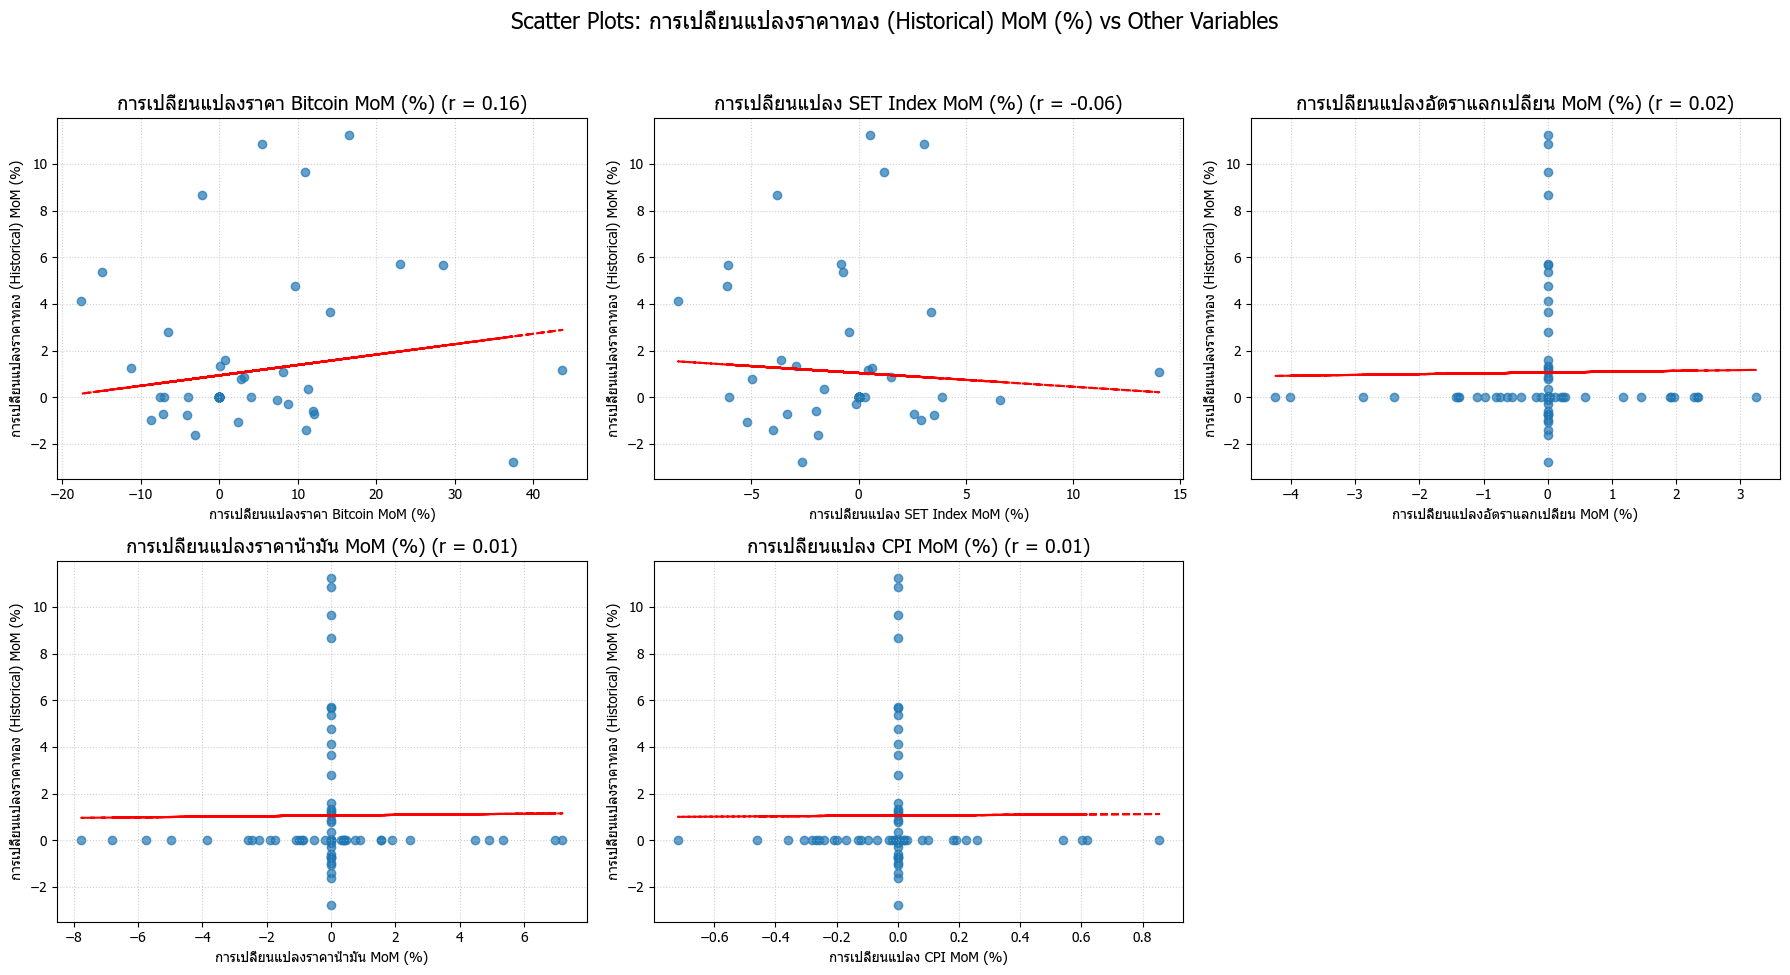

In [32]:
# Cell 13: Multivariate Analysis - Scatter Plots

# กำหนดตัวแปร X ที่ต้องการเปรียบเทียบกับ Y
target_y = 'gold_bar_sell_hist_MoM_Change'
x_variables = [
    'Bitcoin_Price_Close_MoM_Change',
    'SET_Index_Close_MoM_Change',
    'mid_rate_MoM_Change',
    'Petroleum_Price_USD_per_Gal_MoM_Change',
    'CPI_Index_MoM_Change'
]

# กรองข้อมูลที่มีค่า MoM Change ครบถ้วน
scatter_df = final_combined_df[[target_y] + x_variables].dropna()

num_plots = len(x_variables)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten() # แปลงเป็น array 1 มิติ

# ปิด subplots ที่ไม่ได้ใช้
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle(f'Scatter Plots: {thai_names_full.get(target_y)} vs Other Variables', fontsize=16, y=1.0)

for i, x_col in enumerate(x_variables):
    ax = axes[i]
    
    # พล็อต Scatter Plot
    ax.scatter(scatter_df[x_col], scatter_df[target_y], alpha=0.7)
    
    # เพิ่มเส้น Trend Line
    z = np.polyfit(scatter_df[x_col], scatter_df[target_y], 1)
    p = np.poly1d(z)
    ax.plot(scatter_df[x_col], p(scatter_df[x_col]), "r--", linewidth=1.5)
    
    # คำนวณ Correlation Coefficient (r)
    r_value = scatter_df[x_col].corr(scatter_df[target_y])
    
    ax.set_title(f'{thai_names_full.get(x_col, x_col)} (r = {r_value:.2f})', fontsize=14)
    ax.set_xlabel(thai_names_full.get(x_col, x_col))
    ax.set_ylabel(thai_names_full.get(target_y, target_y))
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("multivariate_scatter_plots.png")
print("Saved Scatter Plots: multivariate_scatter_plots.png")